In [1]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image
# import data handling tools
#import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [2]:
import cv2

In [4]:
# Generate data paths with labels
data_dir = "C:\\Users\\ade14\\OneDrive\\Desktop\\forex_Data"
filepaths = []
labels = []

folds = os.listdir(data_dir)

for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [5]:
df

,filepaths,labels
0,C:\Users\ade14\OneDrive\Desktop\forex_Data\BUY...,BUY
1,C:\Users\ade14\OneDrive\Desktop\forex_Data\BUY...,BUY
2,C:\Users\ade14\OneDrive\Desktop\forex_Data\BUY...,BUY
3,C:\Users\ade14\OneDrive\Desktop\forex_Data\BUY...,BUY
4,C:\Users\ade14\OneDrive\Desktop\forex_Data\BUY...,BUY
...,...,...
235,C:\Users\ade14\OneDrive\Desktop\forex_Data\SEL...,SELL
236,C:\Users\ade14\OneDrive\Desktop\forex_Data\SEL...,SELL
237,C:\Users\ade14\OneDrive\Desktop\forex_Data\SEL...,SELL
238,C:\Users\ade14\OneDrive\Desktop\forex_Data\SEL...,SELL


In [6]:
# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)

# valid and test dataframe
#valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

In [7]:
# crobed image size
batch_size = 4
img_size = (400, 400)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Recommended : use custom function for test data batch size, else we can use normal batch size.
ts_length = len(dummy_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

# This function which will be used in image data generator for data augmentation, it just take the image and return it again.
def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar, zoom_range=0.1)
ts_gen = ImageDataGenerator(preprocessing_function= scalar, zoom_range=0.1)
train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( dummy_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

# Note: we will use custom test_batch_size, and make shuffle= false
#test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
 #                                   color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)

Found 192 validated image filenames belonging to 2 classes.
Found 48 validated image filenames belonging to 2 classes.


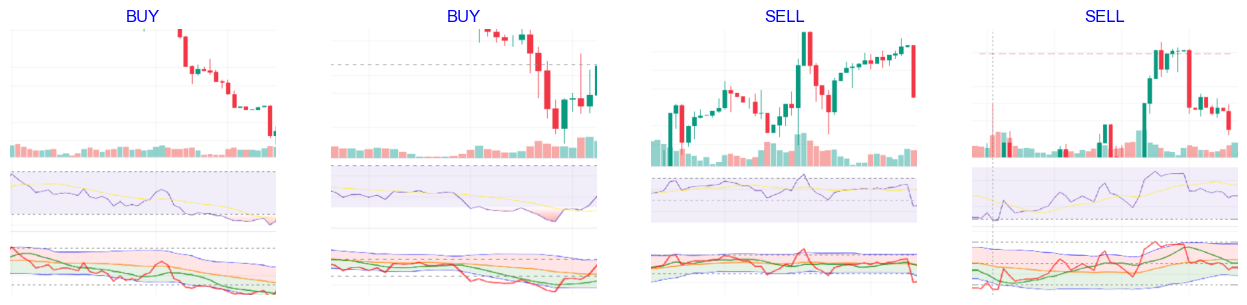

In [8]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

# calculate number of displayed samples
length = len(labels)        # length of batch size
sample = min(length, 25)    # check if sample less than 25 images

plt.figure(figsize= (20, 20))
for i in range(sample):
    plt.subplot(5, 5, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

In [9]:
# Create Model Structure
img_size = (400, 400)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(1024, kernel_regularizer= regularizers.l2(0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    #Dropout(rate= 0.1, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)          │ ?                           │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,783,535 (41.14 MB)

 Trainable params: 10,696,232 (40.80 MB)

 Non-trainable params: 87,303 (341.03 KB)

In [10]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(patience=1, verbose=1)

epochs = 20   # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, 
                    validation_steps= None, shuffle= False)

Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 275s 4s/step - accuracy: 0.5632 - loss: 30.1790 - val_accuracy: 0.5000 - val_loss: 43.3738
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 161s 3s/step - accuracy: 0.6645 - loss: 23.0138 - val_accuracy: 0.5625 - val_loss: 19.9169
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 184s 4s/step - accuracy: 0.6593 - loss: 17.2200 - val_accuracy: 0.6875 - val_loss: 14.6862
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 179s 4s/step - accuracy: 0.6736 - loss: 14.3259 - val_accuracy: 0.6667 - val_loss: 13.2250
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 156s 3s/step - accuracy: 0.6819 - loss: 12.4094 - val_accuracy: 0.4792 - val_loss: 11.7986
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 162s 3s/step - accuracy: 0.6608 - loss: 11.0530 - val_accuracy: 0.8333 - val_loss: 10.0390
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 167s 3s/step - accuracy: 0.7289 - loss: 9.8101 - val_accuracy: 0.7917 - val_loss: 9.0870
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - accuracy: 0.7578 - loss: 8.6509 - val_accuracy

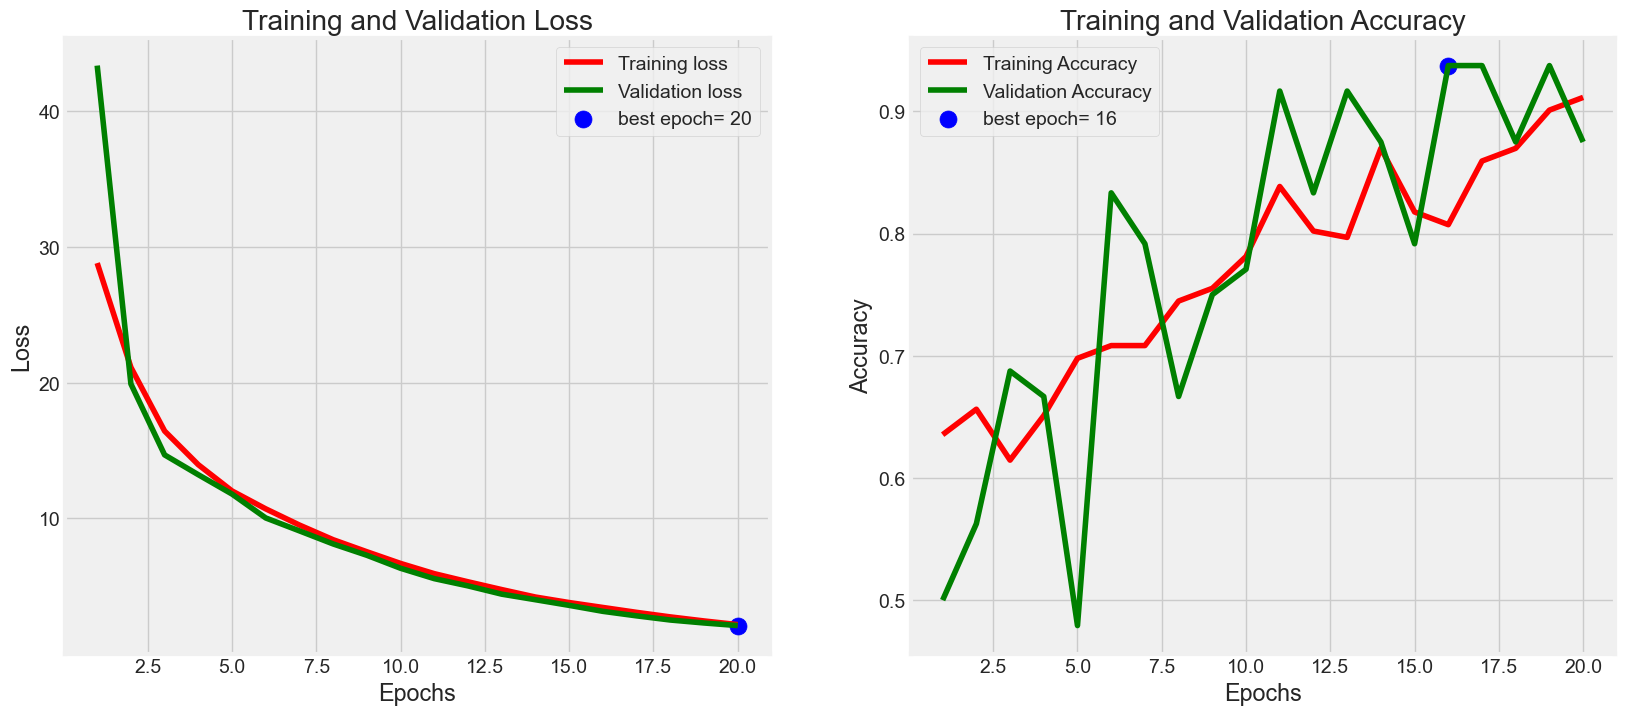

In [11]:

# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [12]:
ts_length = len(dummy_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
#test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
#print("Test Loss: ", test_score[0])
#print("Test Accuracy: ", test_score[1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step - accuracy: 1.0000 - loss: 1.9559
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step - accuracy: 1.0000 - loss: 1.9694
Train Loss:  1.9559406042099
Train Accuracy:  1.0
--------------------
Validation Loss:  1.9693987369537354
Validation Accuracy:  1.0
--------------------


In [13]:
preds = model.predict(valid_gen)
y_pred = np.argmax(preds, axis=1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 568ms/step


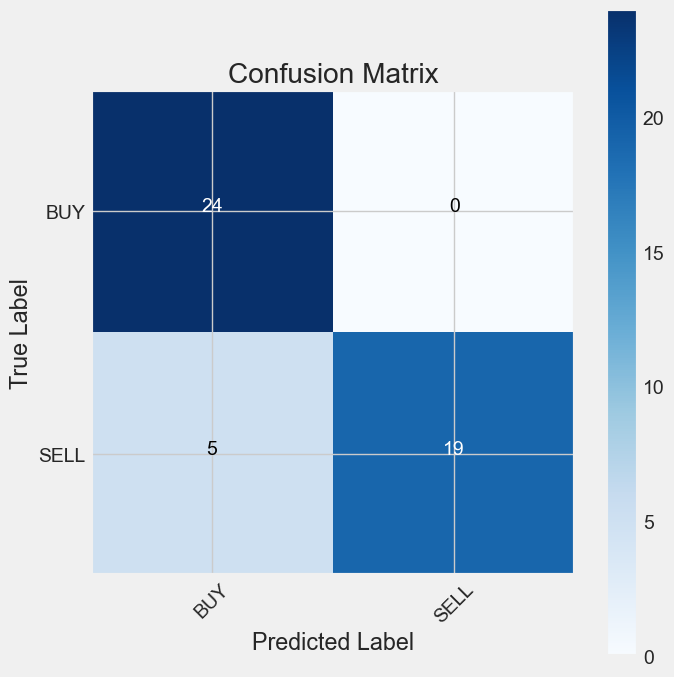

In [17]:
g_dict = valid_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(valid_gen.classes, y_pred)

plt.figure(figsize= (7, 7))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()


In [18]:
# Classification report
print(classification_report(valid_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

         BUY       0.83      1.00      0.91        24
        SELL       1.00      0.79      0.88        24

    accuracy                           0.90        48
   macro avg       0.91      0.90      0.89        48
weighted avg       0.91      0.90      0.89        48



In [19]:
#Save the model
model.save('forex.h5')